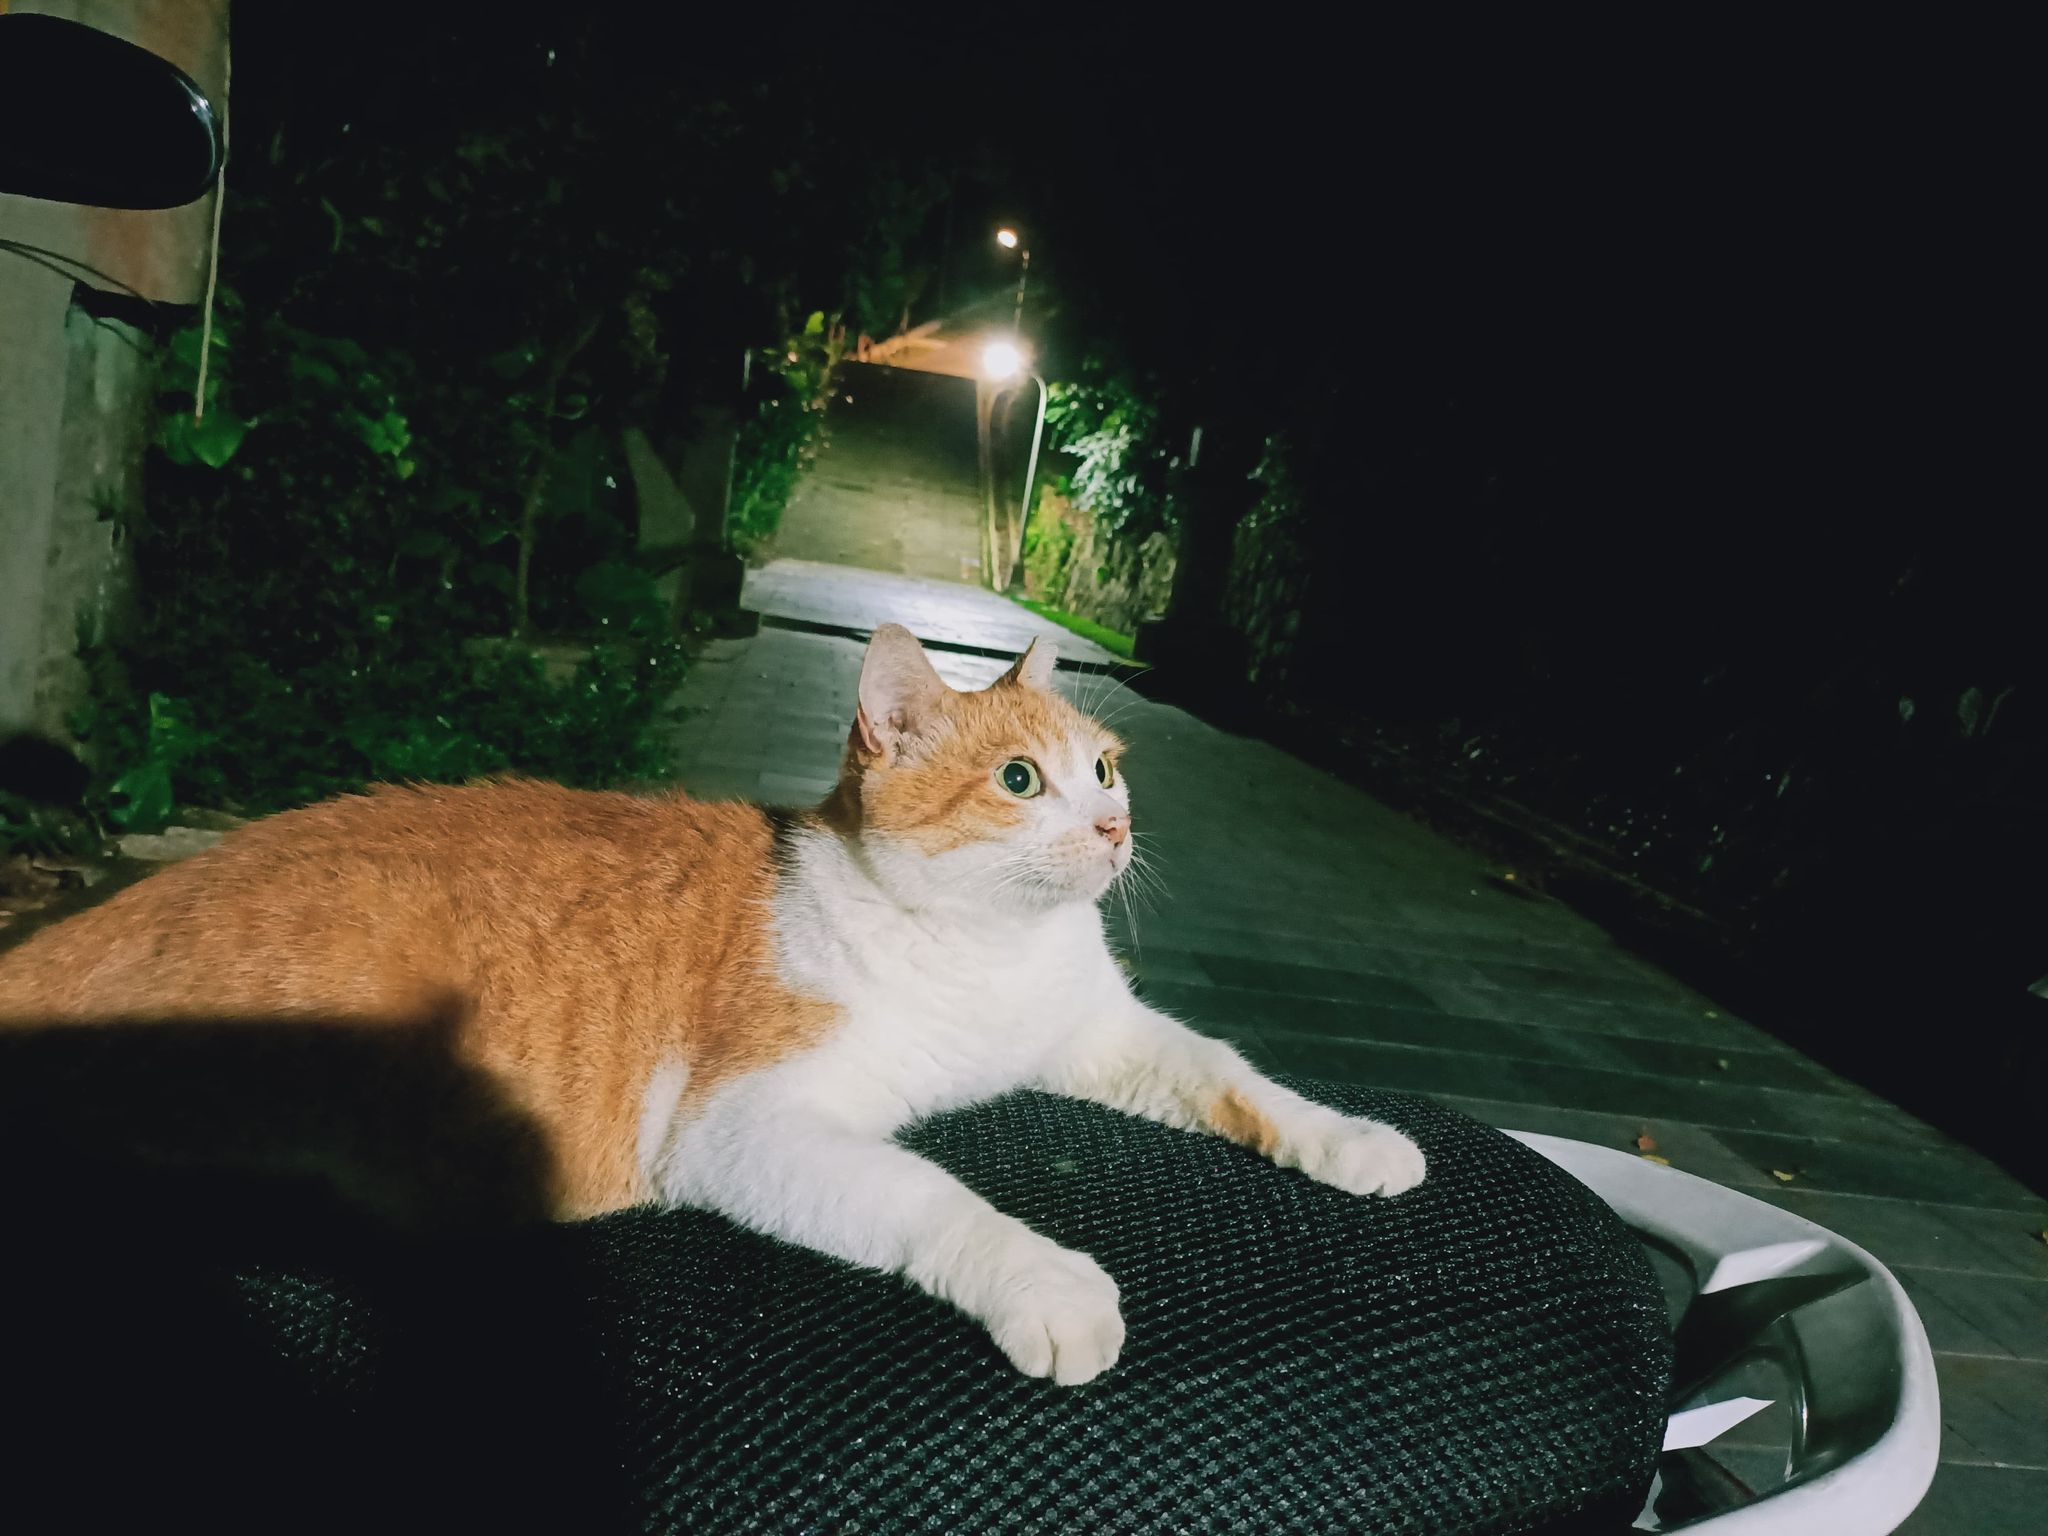

In [34]:
from typing import List, Tuple, Dict

import numpy as np
import onnxruntime as ort
from PIL import Image as PILImage

image = PILImage.open("/Users/clay/Pictures/Mimi/mimi.jpg")
image

In [2]:
session = ort.InferenceSession("./models/u2net.onnx")

In [7]:
session.get_inputs()[0].name

'input.1'

In [35]:
def normalize(
    img: PILImage,
    mean: Tuple[float, float, float] = (0.485, 0.456, 0.406),
    std: Tuple[float, float, float] = (0.229, 0.224, 0.225),
    size: Tuple[int, int] = (320, 320),
) -> Dict[str, np.ndarray]:
    img = img.convert("RGB").resize(size, PILImage.LANCZOS)

    img_array = np.array(img)
    img_array = img_array / np.max(img_array)

    tmp_img = np.zeros((img_array.shape[0], img_array.shape[1], 3))
    tmp_img[:, :, 0] = (img_array[:, :, 0] - mean[0]) / std[0]
    tmp_img[:, :, 1] = (img_array[:, :, 1] - mean[1]) / std[1]
    tmp_img[:, :, 2] = (img_array[:, :, 2] - mean[2]) / std[2]

    tmp_img = tmp_img.transpose((2, 0, 1))

    return np.expand_dims(tmp_img, 0).astype(np.float32)

In [21]:
input_image = normalize(image)

In [22]:
input_data = {session.get_inputs()[0].name: input_image}

In [23]:
output_data = session.run(None, input_data)

In [29]:
output_data[0].shape

(1, 1, 320, 320)

In [30]:
image.size

(2048, 1536)

In [36]:
def postprocess(output_data: List[np.ndarray], image_size: Tuple[int, int]) -> List[PILImage.Image]:
    pred = output_data[0][:, 0, :, :]

    pred_max = np.max(pred)
    pred_min = np.min(pred)

    pred = (pred - pred_min) / (pred_max - pred_min)
    pred = np.squeeze(pred)

    mask = PILImage.fromarray((pred * 255).astype("uint8"), mode="L")
    mask = mask.resize(image_size, PILImage.LANCZOS)

    return [mask]

In [37]:
masks = postprocess(output_data=output_data, image_size=image.size)

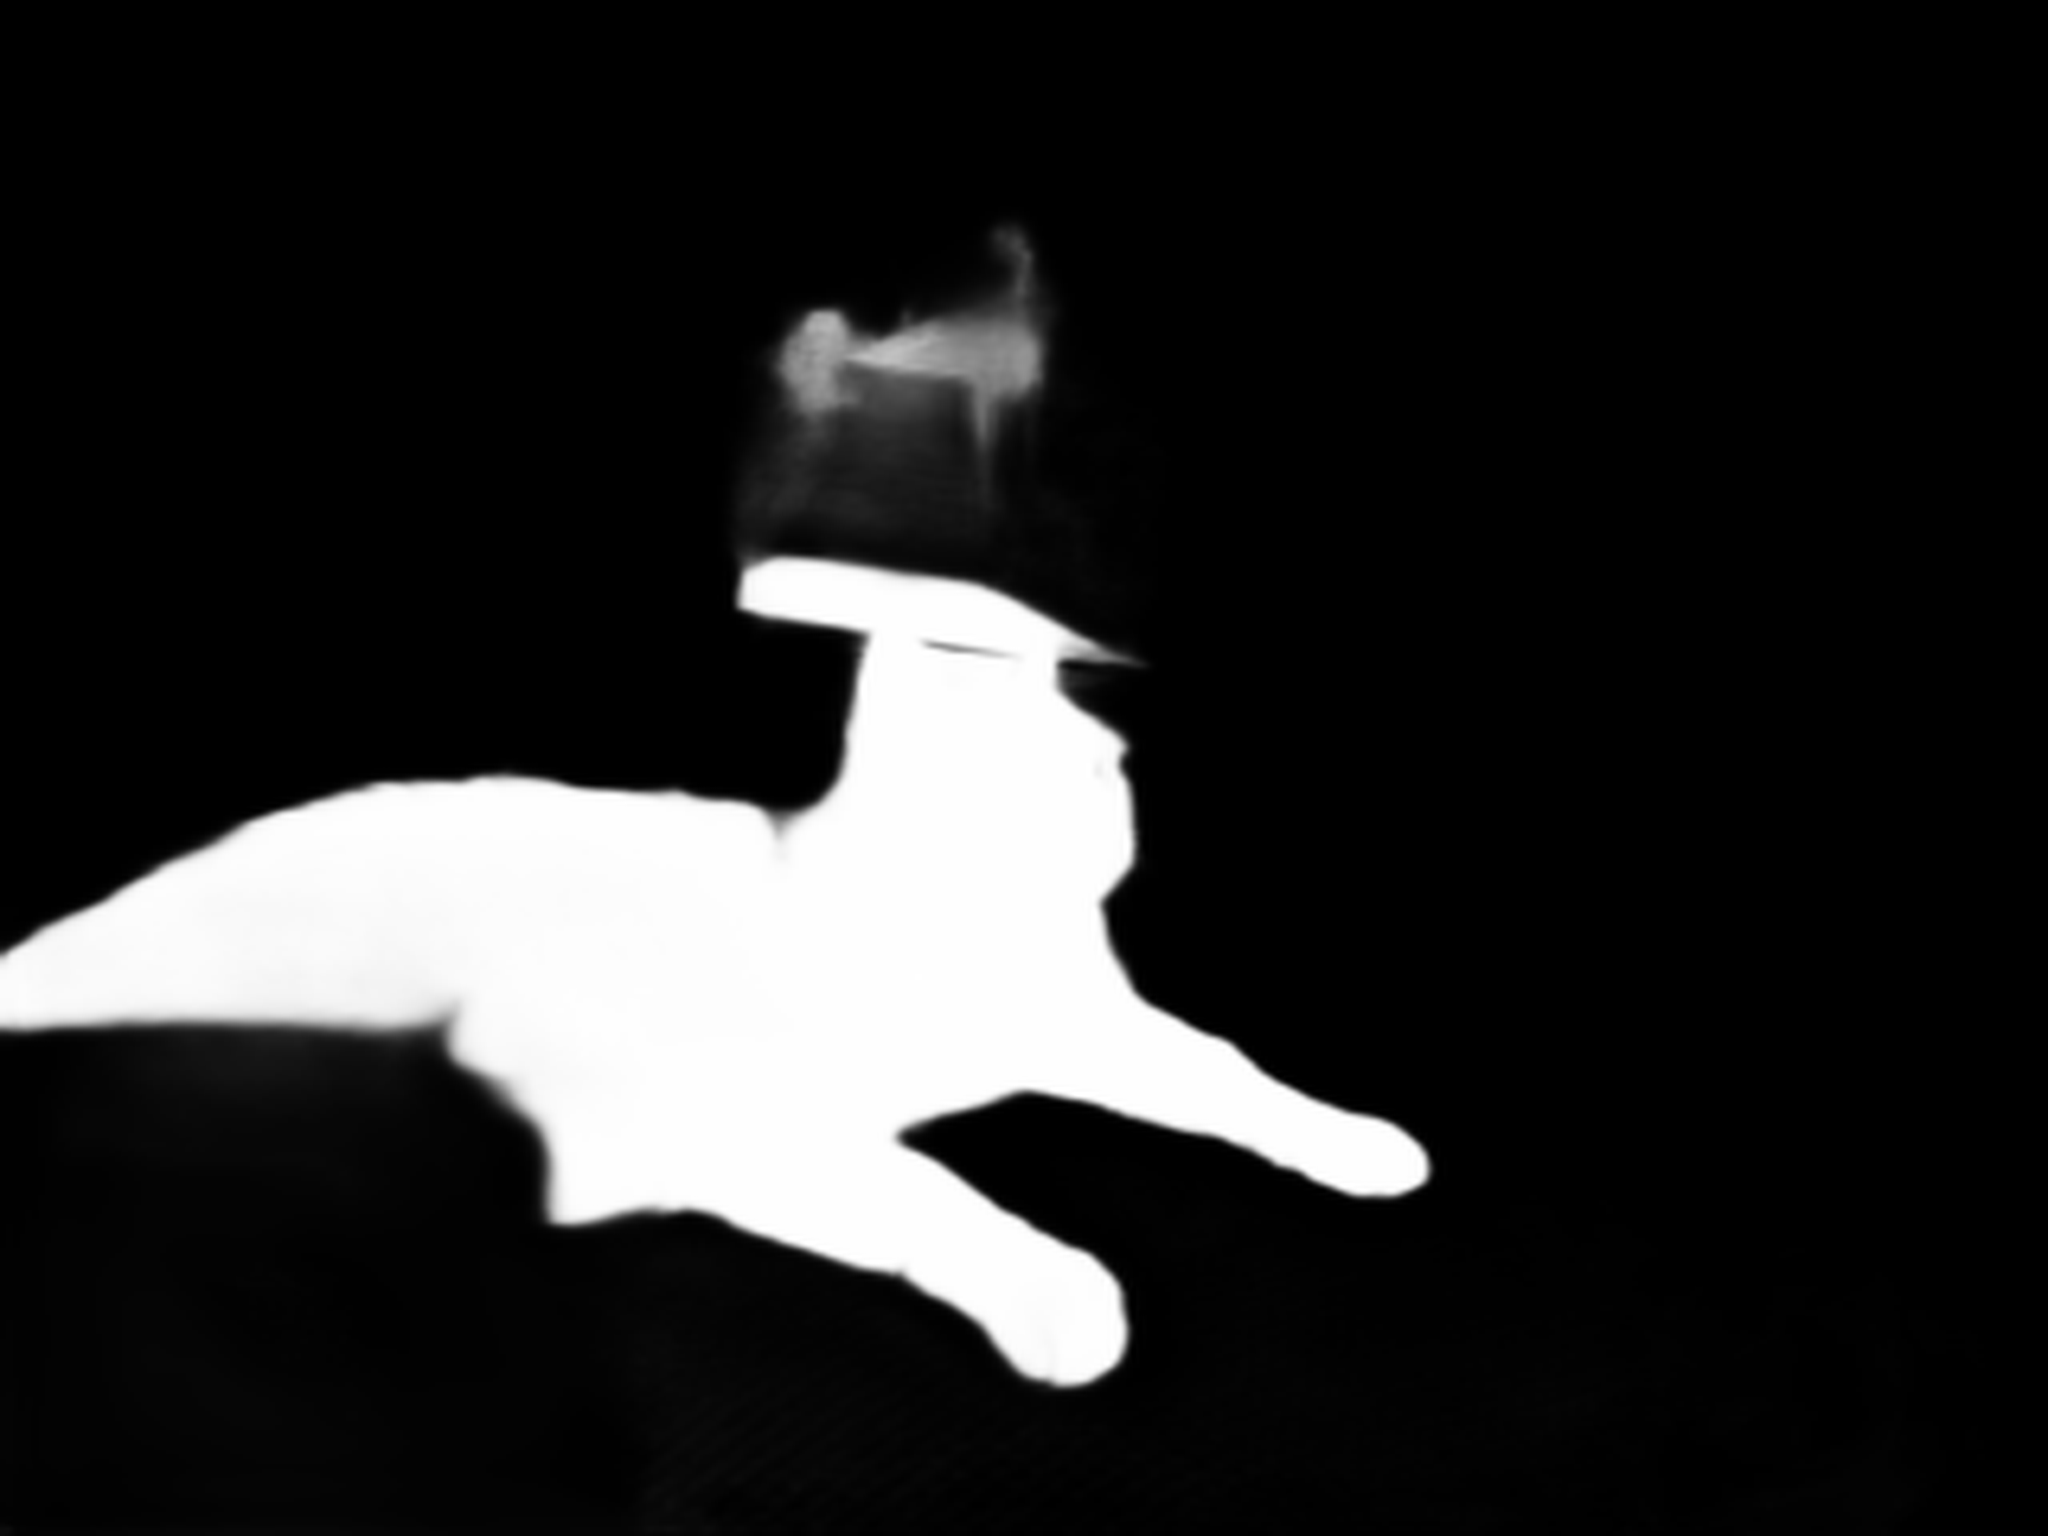

In [39]:
masks[0]

In [41]:
def naive_cutout(img: PILImage, mask: PILImage) -> PILImage:
    img.putalpha(mask)
    return img

def remove(
    img:  PILImage,
    masks: List[PILImage.Image],
) -> PILImage:
    for mask in masks:
        cutout = naive_cutout(img, mask)

    return cutout

In [43]:
new_image = remove(image, masks)

In [46]:
new_image.show()